In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(precision = 3, suppress = True)

## 1D second order equation $-\frac{d}{dx}\left((1+\frac{1}{4}\sin {2\pi x})\frac{d\Psi}{dx}\right) + \nu \Psi=- 2\pi^2 \cos{2\pi x}\cos{4\pi x} + 16\pi^2(1+\frac{1}{4}\sin {2\pi x})\sin{4\pi x} + \nu \sin{4\pi x}$ with periodic BC $\Psi(0)=\Psi(1)$, $\Psi'(0)=\Psi'(1)$

## Exact solution: $\Psi(x) = \sin{4\pi x}$

In [89]:
nu = 5

In [106]:
from keras import backend as K

class BiasLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(BiasLayer, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        print(input_shape)
        self.bias = self.add_weight('bias',
                                    shape=input_shape[1:],
                                    initializer='glorot',
                                    trainable=True)
    def call(self, x):
        return x + self.bias

class ConstantTensorInitializer(tf.keras.initializers.Initializer):
  """Initializes tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, shape, dtype=None):
    return self.t

  def get_config(self):
    return {'t': self.t}

class ConstantTensorConstraint(tf.keras.constraints.Constraint):
  """Constrains tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, w):
    return self.t

  def get_config(self):
    return {'t': self.t}

# all you need to create a mask matrix M, which is a NxN identity matrix
# and you can write a contraint like below
class DiagonalWeight(tf.keras.constraints.Constraint):
    """Constrains the weights to be diagonal.
    """
    def __call__(self, w):
        N = K.int_shape(w)[-1]
        m = K.eye(N)
        v = w*m
        return v

In [142]:
def init_model(nb_hidden_layers, nb_nodes_per_layer, m_periodic, n_periodic, omega, input_dim):

    # Append hidden layers
    all_layers = []

    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    input_model = tf.keras.layers.InputLayer(input_shape= (input_dim,), name='input_model')
    model.add(input_model)

    # Construct first omega matrix
    omega_each_dim = omega*np.ones((input_dim,1))
    Omega_matrix = np.array([])

    for dim in range(input_dim):
        Omega_dim = np.zeros((m_periodic, input_dim))
        Omega_dim[:,dim] = omega_each_dim[dim,0]*np.ones((m_periodic,))
        Omega_matrix = np.vstack([Omega_matrix,Omega_dim]) if Omega_matrix.size else Omega_dim

    Omega = tf.Variable(Omega_matrix.T,dtype=tf.float32)

    # Create first C^inf periodic layers L_p(m,n)
    first_periodic_layer = tf.keras.layers.Dense(m_periodic*input_dim,
                                                 activation = tf.math.cos,
                                                 use_bias = True,
                                                 trainable = True,
                                                 name = 'first_periodic_layer',
                                                 kernel_initializer = ConstantTensorInitializer(Omega),
                                                 kernel_constraint = ConstantTensorConstraint(Omega),
                                                 bias_initializer = 'glorot_normal')
    all_layers.append(first_periodic_layer)
    model.add(first_periodic_layer)

    second_periodic_layer = tf.keras.layers.Dense(m_periodic*input_dim,
                                                  activation = 'tanh',
                                                  use_bias = True,
                                                  trainable = True,
                                                  name = 'second_periodic_layer',
                                                  kernel_constraint = DiagonalWeight(),
                                                  kernel_initializer = 'glorot_normal',
                                                  bias_initializer = 'glorot_normal')
    all_layers.append(second_periodic_layer)
    model.add(second_periodic_layer)

    # create the rest of the network (substitute other code here also)
    for layer in range(nb_hidden_layers):
        if layer == nb_hidden_layers-1:
            layer_name = 'first_to_last_hidden_layer'
        else:
            layer_name = 'hidden_layer_' + str(layer)

        hidden_layer = tf.keras.layers.Dense(nb_nodes_per_layer, 
                                        activation='tanh',
                                        name=layer_name,
                                        kernel_initializer= 'glorot_normal')
                                        #bias_initializer= weight_bias_initializer,
                                        #dtype=tf.float32)
        all_layers.append(hidden_layer)
        model.add(hidden_layer)

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [153]:
nb_hidden_layers = 3
nb_nodes_per_layer = 30

input_dim = 1
m_periodic = 11
n_periodic = 30

L_period = 1.0 #2*np.pi
omega = 2*np.pi/L_period
# Initialize model aka u_\theta
model4 = init_model(nb_hidden_layers, nb_nodes_per_layer, m_periodic, n_periodic, omega, input_dim)
model4.summary()


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_periodic_layer (Dense  (None, 11)               22        
 )                                                               
                                                                 
 second_periodic_layer (Dens  (None, 11)               132       
 e)                                                              
                                                                 
 hidden_layer_0 (Dense)      (None, 30)                360       
                                                                 
 hidden_layer_1 (Dense)      (None, 30)                930       
                                                                 
 first_to_last_hidden_layer   (None, 30)               930       
 (Dense)                                                         
                                                     

In [154]:
a = 0
b = 1
N = 18
h = (b - a)/(N + 1)

#domain discretization to be used as input data
x = []
for i in range(N + 2):
    x.append(a + i*h)
input_data = np.array(x)
input_data = input_data.reshape(N+2,1)

In [155]:
def trainStep(x,opt):
    
    L = len(x)
    
    # Outer gradient for model parameters
    with tf.GradientTape() as tape:
        
        # Inner gradient for first derivative of N wrt x
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            
            # Inner inner gradient for second derivative of N wrt x
            with tf.GradientTape() as tape2:
                tape2.watch(x)
            
                N = model4([x])
            
            Nx = tape2.gradient(N, x)
        Nxx = tape1.gradient(Nx, x)
        
        # Plug trial solution into ODE:
        eqn = - Nx * np.pi /2 * np.cos(2*np.pi*x) - Nxx * (1 + 1/4 * np.sin(2*np.pi*x)) + nu * N - \
        (- 2* np.pi**2 * np.cos(2*np.pi*x) * np.cos(4*np.pi*x) + \
        (1 + 1/4 * np.sin(2*np.pi*x)) * (16*np.pi**2 * np.sin(4*np.pi*x)) + nu * np.sin(4*np.pi*x))  
        
        loss = tf.reduce_sum(tf.square(eqn)) #+ \
        #(tf.squeeze(N[0]) - tf.squeeze(N[L-1]))**2 + (tf.squeeze(Nx[0]) - tf.squeeze(Nx[L-1]))**2  
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model4.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model4.trainable_variables))
    
    
    return loss

In [156]:
def PINNtrain(x, epochs):
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam()
    epoch_loss = np.zeros(epochs)
    
    # Main training loop
    for i in range(epochs):
        
        PDEloss = trainStep(x,opt)
        epoch_loss[i] = PDEloss
        
        if (np.mod(i, 100)==0):
          print("PDE loss in {}th epoch: {: 1.1e}.".format(i, PDEloss.numpy()))
    
    return epoch_loss

In [157]:
epochs = 10000
loss = PINNtrain(tf.convert_to_tensor(input_data, dtype = float),epochs)
loss

PDE loss in 0th epoch:  3.1e+05.
PDE loss in 100th epoch:  2.8e+04.
PDE loss in 200th epoch:  8.3e+02.
PDE loss in 300th epoch:  2.2e+02.
PDE loss in 400th epoch:  9.6e+01.
PDE loss in 500th epoch:  5.7e+01.
PDE loss in 600th epoch:  3.8e+01.
PDE loss in 700th epoch:  2.7e+01.
PDE loss in 800th epoch:  1.9e+01.
PDE loss in 900th epoch:  1.4e+01.
PDE loss in 1000th epoch:  1.2e+01.
PDE loss in 1100th epoch:  9.8e+00.
PDE loss in 1200th epoch:  8.5e+00.
PDE loss in 1300th epoch:  7.5e+00.
PDE loss in 1400th epoch:  6.7e+00.
PDE loss in 1500th epoch:  5.9e+00.
PDE loss in 1600th epoch:  5.3e+00.
PDE loss in 1700th epoch:  4.7e+00.
PDE loss in 1800th epoch:  4.1e+00.
PDE loss in 1900th epoch:  3.7e+00.
PDE loss in 2000th epoch:  3.2e+00.
PDE loss in 2100th epoch:  2.9e+00.
PDE loss in 2200th epoch:  2.6e+00.
PDE loss in 2300th epoch:  2.3e+00.
PDE loss in 2400th epoch:  2.0e+00.
PDE loss in 2500th epoch:  1.8e+00.
PDE loss in 2600th epoch:  1.6e+00.
PDE loss in 2700th epoch:  1.4e+00.
PDE 

array([312465.406, 252712.875, 252265.344, ...,      0.842,      0.76 ,
            0.255])

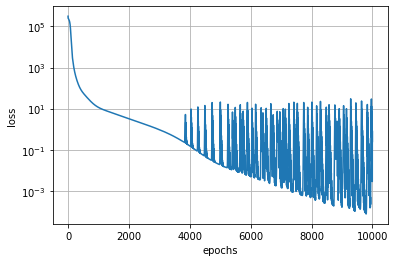

<Figure size 432x288 with 0 Axes>

In [158]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()
plt.savefig('loss.png')

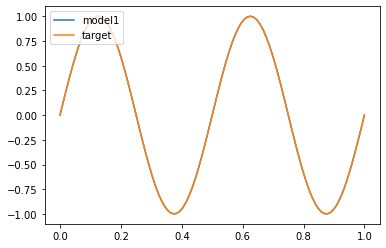

In [159]:
x = np.linspace(0,1,10)
discrete = np.linspace(0,1,100)
target = []

for i in range(100): 
    x_i = discrete[i]
    target.append(np.sin(4*np.pi * x_i)) 
    
#plt.plot(discrete,1 + discrete*model3([discrete]).numpy().T[0], label = 'model1')
plt.plot(discrete, model4([discrete]).numpy().T[0], label = 'model1')
plt.plot(discrete,target, label = 'target')
plt.legend(loc =  'upper left')

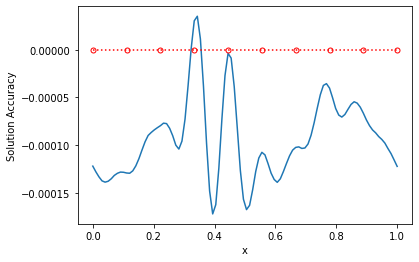

In [160]:
plt.plot(discrete,target-(model4([discrete]).numpy().T[0]))
plt.plot(discrete,[0]*100, ':r')
plt.plot(x,[0]*10, 'o', color = 'red', mfc = 'none', markersize = 5)
plt.ylabel('Solution Accuracy')
plt.xlabel('x')
plt.show()